<a href="https://colab.research.google.com/github/geoffwoollard/calcium_signalling_simulations/blob/master/calcium_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
- develop intuition about Ca2+ concentration around  IP3R with simulations


# TODO
- implement Ca2+ buffer examples in, Wieder et al, 2020, 31.13 Working Examples, pp. 787-791

# Resources

De Young, G. W., & Keizer, J. (1992). A single-pool inositol 1,4,5-trisphosphate-receptor-based model for agonist-stimulated oscillations in Ca2+ concentration. Proceedings of the National Academy of Sciences, 89(20), 9895–9899. http://doi.org/10.1073/pnas.89.20.9895
* early development of IP3 and calcium (activating and deactivation) binding sites.

Schneidman, E., Freedman, B., & Segev, I. (1998). Ion Channel Stochasticity May Be Critical in Determining the Reliability and Precision of Spike Timing. Neural Computation, 10(7), 1679–1703. http://doi.org/10.1162/089976698300017089

Shuai, J.-W., & Jung, P. (2002). Stochastic Properties of Ca2+ Release of Inositol 1,4,5-Trisphosphate Receptor Clusters. Biophysical Journal, 83(1), 87–97. http://doi.org/10.1016/S0006-3495(02)75151-5

Shuai, J. W., & Jung, P. (2003). Optimal ion channel clustering for intracellular calcium signaling. Proceedings of the National Academy of Sciences, 100(2), 506–510. http://doi.org/10.1073/pnas.0236032100

Thul, R., & Falcke, M. (2004). Release Currents of IP3 Receptor Channel Clusters and Concentration Profiles. Biophysical Journal, 86(5), 2660–2673. http://doi.org/10.1016/S0006-3495(04)74322-2

Shuai, J., Pearson, J. E., Foskett, J. K., Mak, D.-O. D., & Parker, I. (2007). A Kinetic Model of Single and Clustered IP3 Receptors in the Absence of Ca2+ Feedback. Biophysical Journal, 93(4), 1151–1162. http://doi.org/10.1529/biophysj.107.108795
* developed 9 state 4mer model used in subsequent studies (addition of a 9th locked state)

Shuai, J., Pearson, J. E., & Parker, I. (2008). Modeling Ca2+ Feedback on a Single Inositol 1,4,5-Trisphosphate Receptor and Its Modulation by Ca2+ Buffers. Biophysical Journal, 95(8), 3738–3752. http://doi.org/10.1529/biophysj.108.137182
* extended Shuai et al (2007)

Rüdiger, S., Nagaiah, C., Warnecke, G., & Shuai, J. W. (2010). Calcium domains around single and clustered IP3 receptors and their modulation by buffers. Biophysical Journal, 99(1), 3–12. http://doi.org/10.1016/j.bpj.2010.02.059

Wieder, N., Fink, R., & von Wegner, F. (2015). Exact Stochastic Simulation of a Calcium Microdomain Reveals the Impact of Ca2+ Fluctuations on IP3R Gating. Biophysical Journal, 108(3), 557–567. http://doi.org/10.1016/j.bpj.2014.11.3458
* very clearly written
* simple model (no complicated grid), from what I can tell.
* comments on reusing random numbers and optimized data structure in ref (34)
* uses extention of classical Gillespie algorithm (ref 33)

Falcke, M., Moein, M., Tilunaite, A., Thul, R., & Skupin, A. (2018). On the phase space structure of IP3 induced Ca2+ signalling and concepts for predictive modeling. Chaos, 28(4), 1–10. http://doi.org/10.1063/1.5021073

Wieder, N., Fink, R. H. A., & von Wegner, F. (2020). Simulation Strategies for Calcium Microdomains and Calcium Noise. Advances in Experimental Medicine and Biology, 1131, 771–797. http://doi.org/10.1007/978-3-030-12457-1_31
* Good overview, including pedagogical examples.

# Set up

In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg

<function scipy.linalg.decomp.eig>

# Chemical Langevin Equation (CLE)

## Example 1: Two Buffers (weak and strong)
* Calcium with two buffers (fast and slow)
  * The ratio of $k_{on}$ and $k_{off}$ determines equilibrium constants (strong or weak buffers), but their absolute scale determines if they are quick or slow. This effects the noise, which is temporal.
  * Buffer 1
$$
Ca^{2+} + B_1 \overset{c_1^+}\rightarrow CaB_1 \\
CaB_1 \overset{c_1^-}\rightarrow  Ca^{2+} + B_1 \\
c_1^+ = 1.66*10^{-4} ms^{-1} \\ 
c_1^- = 0.1 ms^{-1} \\ 
[B]_T = [BCa] + [B] = 100 \mu M \\
[Ca2+]_{eq} = 0.1 \mu M \\
\implies [BCa]_{eq} = \frac{[B]_T[Ca2+]_{eq}}{c_1^-/c_1^+ + [Ca2+]_{eq}}
$$

  * Buffer 2
$$
Ca^{2+} + B_2 \overset{c_2^+}\rightarrow CaB_2 \\
CaB_2 \overset{c_2^-}\rightarrow  Ca^{2+} + B_2 \\
c_2^+ = 1.66*10^{-5}ms^{-1} \\ 
c_2^- = 0.01*10^{-4}ms^{-1}
$$

The theoretical grounding of $c_1^+$, etc in terms of rates is explained in Wieder et al. Briefly, for the buffering reaction we have $V = (1 um)^3 = 1 fL$, $k_{on} = 1 \ (\text{uM ms})^{-1}$, and $k_{off} = 1 \ \text{ms}^{-1}$
* $c_{on} = k_{on}/(VN_a) = 
(\frac{0.1}{10 ^{-6} \text{mol L}^{-1} \text{ms}})
(\frac{1}{10^{-15}\text{L}})
(\frac{mol}{6.022 \cdot 10^{23}})
=1.66 \cdot 10^{-4} \text{ms}^{-1}
  $
* $c_{off} = k_{off} = 0.1 \text{ms}^{-1}
$

In [ ]:

c1p = 1/6.02214*1e-3
c1m = 0.1
c2p = 1/6.02214*1e-4
c2m = 0.01

Bt = 100*60.2214/.1
Ca_eq = 60.2214
BCa_eq = (Bt*Ca_eq)/(c1m/c1p+Ca_eq)
B_eq = Bt - BCa_eq
B_eq,BCa_eq

X0 = np.array([Ca_eq, B_eq, B_eq, BCa_eq, BCa_eq],dtype=np.float32).round(0)
X0

array([   60., 54747., 54747.,  5475.,  5475.], dtype=float32)

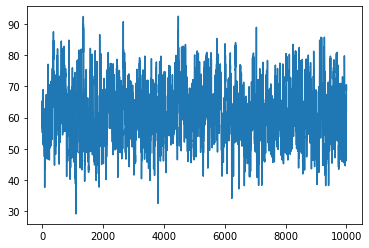

In [ ]:
c1p = 1.66e-4
c1m = 0.1
c2p = 1.66e-5
c2m = 0.01

#0.1*5476, 1.66e-4*54755*60
Bt = 100*60.22/.1
Ca_eq = 60.22
BCa_eq = (Bt*Ca_eq)/(c1m/c1p+Ca_eq) # c1m/c1p = c2m/c2p so equilibrium for buffers 1 and 2 the same
B_eq = Bt - BCa_eq
X0 = np.array([Ca_eq, B_eq, B_eq, BCa_eq, BCa_eq],dtype=np.float32).round(0) # state vector

#X0 = np.array([60, 54755, 54755, 5476, 5476],dtype=np.float32) 
V = np.array([[-1,-1,0,+1,0],
              [+1,+1,0,-1,0],
              [-1,0,-1,0,1],
              [1,0,1,0,-1],
              ])

Vsize = V.size
I,J = V.shape
Xt = X0
Xsize = X0.size

dt = 0.01 # ms
Ttotal = 100 # ms
Tsteps = np.ceil(Ttotal/dt).astype(int)
Xts = np.zeros((Tsteps,Xsize))

# for time step
for t in range(Tsteps):
  dW = np.random.normal(loc=0,scale=np.sqrt(dt),size=Vsize).reshape(I,J)
  x1t,x2t,x3t,x4t,x5t = Xt

  # model dependent reaction propensity
  a1 = c1p*x1t*x2t
  a2 = c1m*x4t
  a3 = c2p*x1t*x3t
  a4 = c2m*x5t
  a = np.array([a1,a2,a3,a4])#.reshape(-1,1)

  # for i in range(Xsize):
  #   v = V[:,i]
  #   dw = dW[:,i]
  #   dxit = np.dot(v,a)*dt + np.dot(v*np.sqrt(a),dw)
  #   Xt[i] += dxit
  #   print(dxit)
  dXt = (V*a.reshape(-1,1)).sum(0)*dt + (V*np.sqrt(a).reshape(-1,1)*dW).sum(0)
  Xt += dXt
  Xt[Xt < 0] = 0 # to prevent negative counts of molecules. see pp 778 and ref 41 in Wieder et al
  Xts[t,:] = Xt

pd.Series(Xts[:,0]).plot()

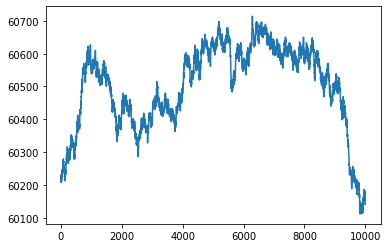

In [ ]:
pd.Series(Xts[:,1]+Xts[:,3]).plot() # the total buffer concentration fluctuates

## Example 2: Buffer and constant diffusion
* Buffer (as before) 
* Diffusion
$$
Ca^{2+} \rightarrow \emptyset \\
\emptyset \rightarrow  Ca^{2+} \\ 
c_D = D_{Ca2+}/(\delta x)^2 = 0.2 \ (ms)^{-1}
$$
  * Where $\delta x$ is the voxel size length ($V^{1/3}$)
  * $D_{Ca2+} = 200 \ \mu m^2s^{-1}$

In [ ]:
dt = 0.01 # ms
Ttotal = 100 # ms
Tsteps = np.ceil(Ttotal/dt).astype(int)
X0 = np.array([60, 54755, 5476],dtype=np.float32) # state vector
V = np.array([[-1,-1,+1],
              [+1,+1,-1],
              [-1,0,0],
              [1,0,0]
              ])
Vsize = V.size
I,J = V.shape
Xt = X0.copy()
Xsize = X0.size
Xts = np.zeros((Tsteps,Xsize))

c1p = 1.66e-4
c1m = 0.1
cd = 0.2

a4 = cd*X0[0] # time independent because bath Ca2+ not changing, and taken as [Ca2+]eq

# for time step
for t in range(Tsteps):
  dW = np.random.normal(loc=0,scale=np.sqrt(dt),size=Vsize).reshape(I,J)
  x1t,x2t,x3t = Xt

  # model dependent reaction propensity
  a1 = c1p*x1t*x2t
  a2 = c1m*x3t
  a3 = cd*x1t
  a4 = a4
  a = np.array([a1,a2,a3,a4])#.reshape(-1,1)

  dXt = (V*a.reshape(-1,1)).sum(0)*dt + (V*np.sqrt(a).reshape(-1,1)*dW).sum(0)
  Xt += dXt
  Xt[Xt < 0] = 0 # to prevent negative counts of molecules. see pp 778 and ref 41 in Wieder et al
  Xts[t,:] = Xt


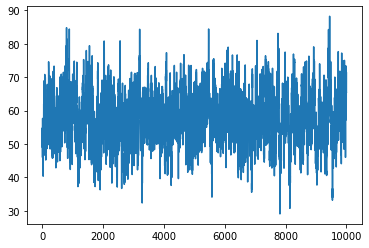

In [ ]:
pd.Series(Xts[:,0]).plot()

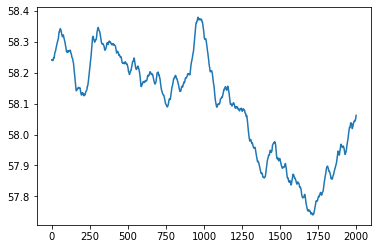

In [ ]:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

N = 4000
X0ts_av = runningMeanFast(Xts[:,0],N)
pd.Series(X0ts_av[N:-N]).plot()

## Example 3: channel opening/closing with buffer and diffusion
This example includes a calcium channel that can open and close.
$$[B]_T = [BCa] + [B] = 10 \mu M \\
k_+ = 0.5 (\mu M ms)^{-1} \\
k_- = 0.25 (ms)^{-1}
$$


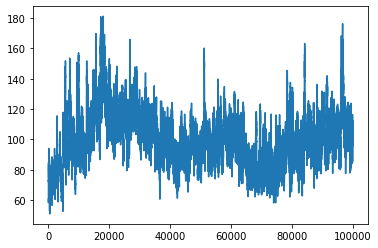

In [ ]:
dt = 0.01 # ms
Ttotal = 1000 # ms
Tsteps = np.ceil(Ttotal/dt).astype(int)
X0 = np.array([60, 5476, 548, 0.5,0.5],dtype=np.float32) # state vector
V = np.array([[-1,-1,+1,0,0], 
              [+1,+1,-1,0,0],
              [-1,0,0,0,0],
              [1,0,0,0,0],
              [0,0,0,-1,+1], # C -> O
              [0,0,0,+1,-1], # O -> C
              [1,0,0,0,0], # O -> O + Ca2+
              ])
Vsize = V.size
I,J = V.shape
Xt = X0.copy()
Xsize = X0.size
Xts = np.zeros((Tsteps,Xsize))


kchp = 0.01 # closed to open (Wieder el al, 2020, pp 790-791: "macroscopic rate constants for ch channel opening and closing as determined from electrophysiological measurements for instance")
kchm = 1 -  kchp # units?

vscale=1
c1p = 1.66e-4#/vscale/5 # for kp=0.5 umol/ms instead of 0.1 umol/ms
c1m = 0.1#*2.5 # for km 0.25 /ms instead of 0.1 /ms
cd = 0.2
cchp = kchp
cchm = kchm
cp = 100 #7.5e-12/(2*1.602e-19)*1e3 # I/(2e) = ~3000 for 1 pA. In literature current is 5-10 pA by Fig 11, p 627 in Foskett, J. K., White, C., Cheung, K.-H., & Mak, D.-O. D. (2007). Inositol Trisphosphate Receptor Ca 2+ Release Channels. Physiological Reviews, 87(2), 593–658. http://doi.org/10.1152/physrev.00035.2006

a4 = cd*X0[0] # time independent because bath Ca2+ not changing

# for time step
for t in range(Tsteps):
  dW = np.random.normal(loc=0,scale=np.sqrt(dt),size=Vsize).reshape(I,J)
  x1t,x2t,x3t,x4t,x5t = Xt

  # open/close channel
  #assert np.isclose(x4t+x5t,1) # how???

  # model dependent reaction propensity
  a1 = c1p*x1t*x2t
  a2 = c1m*x3t
  a3 = cd*x1t # diffuse away based on local [Ca2+]
  a4 = a4 # diffuse in based on bath [Ca2+]
  a5 = cchp*x4t # no calcium dependency for activating or inactivating!
  a6 = cchm*x5t
  a7 = cp*x5t # probability of (constant burst of) calcium release depends on probability of channel being open (where is calcium dependency?)
  a = np.array([a1,a2,a3,a4, a5, a6, a7])#.reshape(-1,1)

  dXt = (V*a.reshape(-1,1)).sum(0)*dt + (V*np.sqrt(a).reshape(-1,1)*dW).sum(0)
  Xt += dXt
  Xt[Xt < 0] = 0 # to prevent negative counts of molecules. see pp 778 and ref 41 in Wieder et al
  Xt[-2:] /= Xt[-2:].sum() # open and closed probability must sum to 1
  Xts[t,:] = Xt

pd.Series(Xts[:,0]).plot()

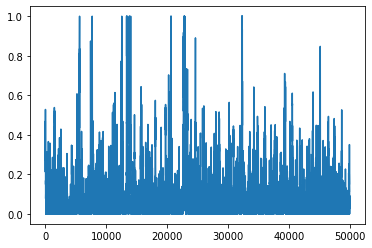

In [ ]:
pd.Series(Xts[:,-1]).plot()

In [ ]:
Xts[:,-1].max()

1.0

## Limitations
Depending on the volume, the copy numbers of the state vector can become negative, which is unphysical. The gaussian approximation to the Poisson distribution breaks down here, and care should be taken for values less than ~100 (e.g. compare the distributions).

# Markov Process
* Shuai et al (2007) extended previous models of the IP3R tetramer and introduced a 9 state model, which binding sites for IP3 and calcium (calcium dependent activating and inhibiting sites). The state of each 1mer of the 4mer can be described by a Markov Process

In [ ]:
##

## Stochastic Transition Matrix
* rows are probability from state row to state col. They sum to 1.

In [ ]:
def compute_P(Ca=0.05,IP3=10,dt=50e-6):

  
  a0 = 540
  b0 = 80
  a1 = 60
  a2 = 0.04
  a3 = 5
  a4 = 0.5
  a5 = 30
  a = np.array([a1,a2,a3,a4,a5])
  k1 = 0.0036 # 3.6 nM Kd for IP3
  k2 = 16
  k3 = 0.8
  k4 = 0.072
  k5 = 0.8
  K = np.array([k1,k2,k3,k4,k5])
  b1,b2,b3,b4,b5 = a*K

  P = np.array([
                [0,b0,0,0,0,0,0,0,0], # Active
                [a0,0,b5,b1,0,a2*Ca,0,0,0], # 110 IP3 Ca_a
                [0,a5*Ca,0,0,b1,0,a2*Ca,0,0], #100 IP3
                [0,a1*IP3,0,0,b5,0,0,a4*Ca,0], # 010 Ca_a
                [0,0,a1*IP3,a5*Ca,0,0,0,0,a4*Ca], # 000
                [0,b2,0,0,0,0,b5,b3,0], #111 IP3 Ca_a Ca_i
                [0,0,b2,0,0,a4*Ca,0,0,b3], # 101 IP3 Ca_i
                [0,0,0,b4,0,a3*IP3,0,0,b5], # 011 Ca_a Ca_i
                [0,0,0,0,b4,0,a3*IP3,a5*Ca,0], # 001 Ca_i
                ])
  dt=50e-6 # 10 us 1.6ms max step size, otherwise prob too big
  P *= dt
  P[np.diag_indices_from(P)] = 1 - P.sum(axis=1) # row sums. stationary probability

  assert np.allclose(np.ones_like(P.sum(1)), P.sum(1))
  assert np.alltrue(P<1)
  return(P)
P = compute_P(Ca=0.05,IP3=10,dt=50e-6)

P[0]

array([0.996, 0.004, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [ ]:
# with np.printoptions(precision=3, suppress=True, threshold=6):
#   for row in P: print(row[:10])

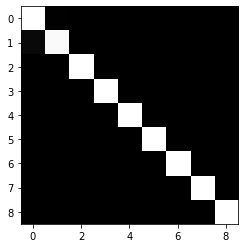

In [ ]:
plt.imshow(np.log(1+P),cmap='gray')

In [ ]:
P[-1]

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       1.800000e-06, 0.000000e+00, 1.250000e-05, 7.500000e-05,
       9.999107e-01])

The probabilities depend on the time step. By increasing the time step, we can speed up the time it takes to transition to the next step. There is no sense having even the largest probability for any state be so small, that we are always staying on that state. We would be simulating doing nothing!

We can quickly check that the maximum transition probability for every state is not too small.



In [ ]:
P_nodiag = (P - np.eye(P.shape[0])*np.diag(P))
P_nodiag.max(1)

array([4.0e-03, 2.7e-02, 7.5e-05, 3.0e-02, 3.0e-02, 1.2e-03, 2.0e-04,
       2.5e-03, 2.5e-03])

We should choose a simulation length where the smallest transition has some probability of occuring. I.e. the inverse of the smallest non zero probability

In [ ]:
P_nodiag[P_nodiag > 0].min()

1.0000000000000001e-07

We have the probabilities. To take a stochastic step, we could draw from a uniform distribution and check the randomly drawn uniform variable against our transition probability... but then we'd have to check if it was between values. Alternatively, we can just treat each row in the transition matrix as the probabilities for a multinomial distrubution and draw a value.

## Stationary state
What initial state do we use? We can pick one, or try to use the most likely state. The most likely state will be the stationary state. This can easily be found by computing the eigens of P. The eigenvector corresponding the the eigenvalue of 1 is the stationary state. However, this has a probability for each state, and we want to simulate a trajectory, where each protomer is only in one state at a time (not probabilistically).

In this case we can simulate many trajectories, starting from an initial state, drawn from a multinomial distribution with probabilities given by the stationary state.

We can also get a sense of how likely a state will be sampled.

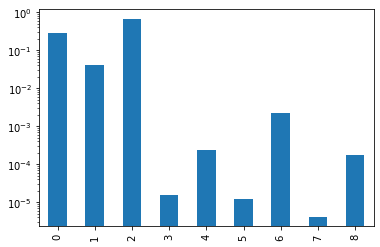

In [225]:
def comp_stationary_state(P):
  # from http://people.duke.edu/~ccc14/sta-663-2016/homework/Homework02_Solutions.html
  lam, vec = scipy.linalg.eig(P, left=True, right=False)

  idx = np.argmin(np.abs(lam - 1))
  w = np.real(vec[:, idx])
  w /= w.sum()
  assert np.allclose(np.dot(w,P),w) # check stationary
  assert np.isclose(w.sum(),1)
  return(w)
w = comp_stationary_state(P)
pd.Series(w).plot.bar()
plt.yscale('log')


In [223]:
w

array([2.83438238e-01, 4.19908500e-02, 6.71904513e-01, 1.51163872e-05,
       2.41885944e-04, 1.21923821e-05, 2.21873063e-03, 4.19479719e-06,
       1.74279044e-04])

We can also check at the end of our simulation, how the trajectory compares to the stationary state. Did we take enough steps that our statistics are independent of the initial state.

We actually have to compute trajectories, in order to apply our open/closed criteria of "at least 3 protomers in the activated state". The stationary state averages over steps and we can't compare the protomers at each step.

In [193]:
state = np.argmax(np.random.multinomial(1,pvals=w,size=1))
state

0

## One protomer

In [ ]:
Ttotal = 10 # in s
Tsteps = int(Ttotal / dt)
np.log10(Tsteps)

5.301029995663981

In [ ]:
%%time
state=-1
Tsteps = int(10**5.5)
states = np.zeros(Tsteps)
for _ in range(Tsteps):
  step = np.random.multinomial(1,pvals=P[state],size=1)
  state = np.argmax(step)
  states[_] = state


CPU times: user 5.5 s, sys: 1.97 ms, total: 5.51 s
Wall time: 5.5 s


In [ ]:
pd.Series(states).value_counts()

2.0    210345
0.0     64932
6.0     29904
1.0      9910
8.0      1053
4.0        83
dtype: int64

## Tetramer

The loop is not parallelizable, since the next state depends on the previous state. However, we can precompute the steps, since they only depend on the state. Then we can just look them up and apply them for a certain path. 

Here we compute a possible transition for every state in every step for the 4mers (over compute), and then we loop through and use the step that we end up having.

In [ ]:
Ttotal = 500 # 500s
Tsteps = int(Ttotal / dt)
np.log10(Tsteps)

7.0

In [ ]:
%%time
def precompute_state_transitions(P,Tsteps):
  state_transitions = np.empty((Tsteps,4, P.shape[0]), dtype=np.int16)
  for state in range(P.shape[0]):
    state_transitions[:,:,state] = np.argmax(np.random.multinomial(1,pvals=P[state],size=4*Tsteps),axis=1).reshape(Tsteps,4)
  return(state_transitions)
state_transitions = precompute_state_transitions(P,Tsteps)

CPU times: user 1min 5s, sys: 234 ms, total: 1min 5s
Wall time: 1min 5s


In [ ]:
%%time
def simulate_markov_process(state_transitions,initial_state):
  Tsteps = state_transitions.shape[0]
  states = np.zeros((Tsteps,4))
  state_4mer = initial_state 
  idx_4mer = np.array([0,1,2,3])
  for t in range(Tsteps):
    state_4mer = state_transitions[t,idx_4mer,state_4mer]
    states[t] = state_4mer
  return(states)

initial_state = np.array([-1,-1,-1,-1])# all 4mer Ca_i
states = simulate_markov_process(state_transitions,initial_state)

CPU times: user 22.6 s, sys: 1.8 ms, total: 22.6 s
Wall time: 22.6 s


In [ ]:
act_states = (states == 0).sum(1)
pd.Series(act_states).value_counts()

1    4075038
0    2658382
2    2548944
3     659848
4      57788
dtype: int64

In [ ]:
open_states = states.sum(1) <= 1
open_states.mean()

0.0090835

(5e-05, 10000000)

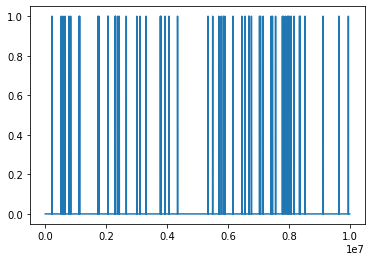

In [ ]:
pd.Series(open_states.astype(int)).plot() # dt = 0.0016, Tsteps=6.25e6
dt, Tsteps


## Biphasic calcium dependency
* The Po is biphasically dependent on [Ca2+]. Let's try to reproduce this. The transition matrix needs to be recomputed for every different [Ca2+]

* TODO: write out states and experiment with different definitions of (open channel) and see if still get biphasic behaviour)

In [330]:
Ttotal = 100 # seconds
Tsteps = int(Ttotal / dt)
np.log10(Tsteps), Tsteps

(6.301029995663981, 2000000)

In [331]:
%%time
ca = [0.001,0.01,0.025,0.05] + np.arange(0.1,1,0.1).tolist() + np.arange(1,10,1).tolist() + np.arange(10,50,5).tolist() + np.arange(50,100,10).tolist() + np.arange(100,1000,100).tolist() #,0.1,0.2,0.3,0.4,0.5,0.1,10,20,35,40,45] 0 for 50
ca = np.array(ca)
open_probs = np.empty_like(ca)
initial_state = 0*np.array([-1,-1,-1,-1])# all 4mer Ca_i
states = np.empty((ca.size,Tsteps,4))
stationary_states = np.empty((ca.size,P.shape[0]))

for i in range(ca.size): # parralelizable loop (ca conditions don't depend on each other)
  P = compute_P(Ca=ca[i],IP3=10,dt=50e-6)
  stationary_states[i] = comp_stationary_state(P)
  state_transitions = precompute_state_transitions(P,Tsteps)
  initial_state = np.argmax(np.random.multinomial(1,pvals=w,size=4),1)
  states[i] = simulate_markov_process(state_transitions,initial_state)
  open_states = (states[i] == 0).sum(1) >= 3 # TODO: experiment with this definition
  open_probs[i] = open_states.mean()

CPU times: user 11min 4s, sys: 467 ms, total: 11min 4s
Wall time: 11min 4s


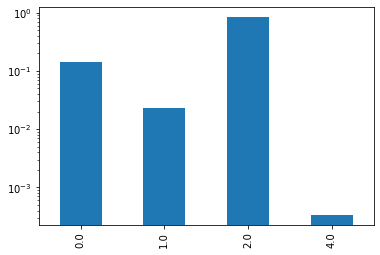

In [315]:
pd.Series(states[1].flatten()).value_counts(normalize=True).sort_index().plot.bar()
plt.yscale('log')

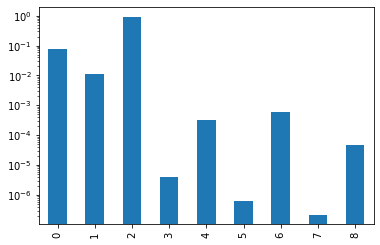

In [316]:
pd.Series(stationary_states[1]).plot.bar()
plt.yscale('log')

This matches very with the stationary state. If we notice that some states are missing in the Markov process, but are present in the stationary state, this means we have not sampled enough to visit these other rare states.

Text(0.5, 1.0, 'Biphasic Open Probability')

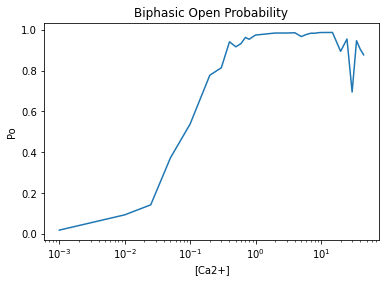

In [317]:
sr = pd.Series(open_probs)
sr.index = ca
ax = sr.plot.line()
ax.set_xlabel('[Ca2+]')
ax.set_ylabel('Po')
plt.xscale('log')
ax.set_title('Biphasic Open Probability')

This Markov Process model recapitulates the experimentally observed biphasic bell shaped open probability. This verified the model. Nature may be more interesting than this simple model. 

If another model predicts new (unique?) bahaviour, and there is a way to experimentally measure the predictions from this model, then we can learn about the microscopic behaviour through the macroscopic observables. This is biophysics!

For instance, we can define an open state as a 4mer with 2 or more activated protomers (instead of 3).

In [336]:
timestr = '202007230_202400'
np.save(timestr+'states.npy',states)
np.save(timestr+'202007230_2024-ca.npy',ca)

array([0.000000e+00, 0.000000e+00, 2.250000e-04, 7.459500e-03,
       2.501900e-02, 9.974250e-02, 1.665910e-01, 2.221610e-01,
       2.570290e-01, 3.186655e-01, 3.126935e-01, 3.514680e-01,
       3.350690e-01, 3.789175e-01, 3.807095e-01, 4.685555e-01,
       4.476710e-01, 4.411975e-01, 4.498565e-01, 3.980590e-01,
       4.260250e-01, 4.381880e-01, 4.160950e-01, 4.116210e-01,
       2.955700e-01, 2.302110e-01, 2.152890e-01, 2.198550e-01,
       1.729785e-01, 1.492615e-01, 1.418955e-01, 9.316950e-02,
       5.834250e-02, 1.094525e-01, 6.563350e-02, 4.947250e-02,
       7.650000e-03, 3.475000e-03])

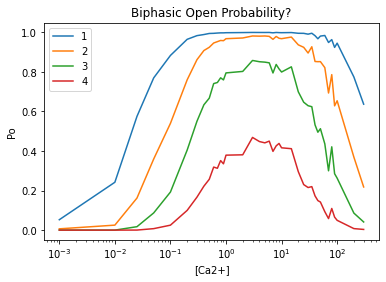

In [339]:
for state_for_open in [1,2,3,4]:
  for i in range(states.shape[0]):
    open_states = (states[i] == 0).sum(1) >= state_for_open
    open_probs[i] = open_states.mean()

  sr = pd.Series(open_probs)
  sr.index = ca
  ax = sr.plot(legend=True, label=state_for_open)
  ax.set_xlabel('[Ca2+]')
  ax.set_ylabel('Po')
  plt.xscale('log')
  ax.set_title('Biphasic Open Probability?')


Here we see that the peak width changes with the number of channels that need to be open to define an open state. To peak width is a measure of the cooperativity of the tetramers.